# Feature Engineering for SOC Estimation
## Stanford TECH 27 Final Project - Notebook 03

This notebook focuses on feature engineering for conventional machine learning models in SOC estimation.
It builds upon the cleaned discharge data from `02_data_cleaning.ipynb`.

### Goals:
1. Load cleaned discharge data from previous notebook
2. Engineer comprehensive features from raw battery measurements
3. Create rolling statistics, lag features, and derived measurements
4. Analyze feature importance and correlations
5. Prepare engineered features for machine learning models

### Output:
- Feature engineering pipeline
- Comprehensive engineered features dataset
- Feature importance analysis and visualization

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
from tqdm import tqdm
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor

# Import our custom utilities
from data_processing_utils import (
    load_cleaned_data, engineer_features, OUTPUT_DIR
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully!
NumPy version: 2.3.2
Pandas version: 2.3.2


## 1. Load Cleaned Data

In [2]:
# Load cleaned discharge data from 02_data_cleaning.ipynb
print("Loading cleaned discharge data...")
cleaned_data = load_cleaned_data()

print(f"\nCleaned data overview:")
print(f"Shape: {cleaned_data.shape}")
print(f"Columns: {list(cleaned_data.columns)}")
print(f"SOC range: {cleaned_data['SOC'].min():.3f} - {cleaned_data['SOC'].max():.3f}")
print(f"Unique batteries: {cleaned_data['battery_id'].nunique()}")
print(f"Unique files: {cleaned_data['filename'].nunique()}")

# Show sample of the data
print(f"\nFirst few rows:")
print(cleaned_data.head())

Loading cleaned discharge data...
Loaded cleaned data: (541510, 11)
Columns: ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_load', 'Voltage_load', 'Time', 'SOC', 'battery_id', 'test_id', 'filename', 'ambient_temperature']
Unique batteries: 30
SOC range: 0.100 to 1.000

Cleaned data overview:
Shape: (541510, 11)
Columns: ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_load', 'Voltage_load', 'Time', 'SOC', 'battery_id', 'test_id', 'filename', 'ambient_temperature']
SOC range: 0.100 - 1.000
Unique batteries: 30
Unique files: 2314

First few rows:
   Voltage_measured  Current_measured  Temperature_measured  Current_load  \
0          4.039277         -0.995093              6.250255           1.0   
1          4.019506         -0.996731              6.302176           1.0   
2          4.004763         -0.992845              6.361645           1.0   
3          3.992863         -0.995957              6.399692           1.0   
4          3

## 2. Sample Data for Feature Engineering Analysis

Sample data from battery: B0047
Sample shape: (23332, 11)
SOC range in sample: 0.149 - 1.000
Duration: 1.71 hours


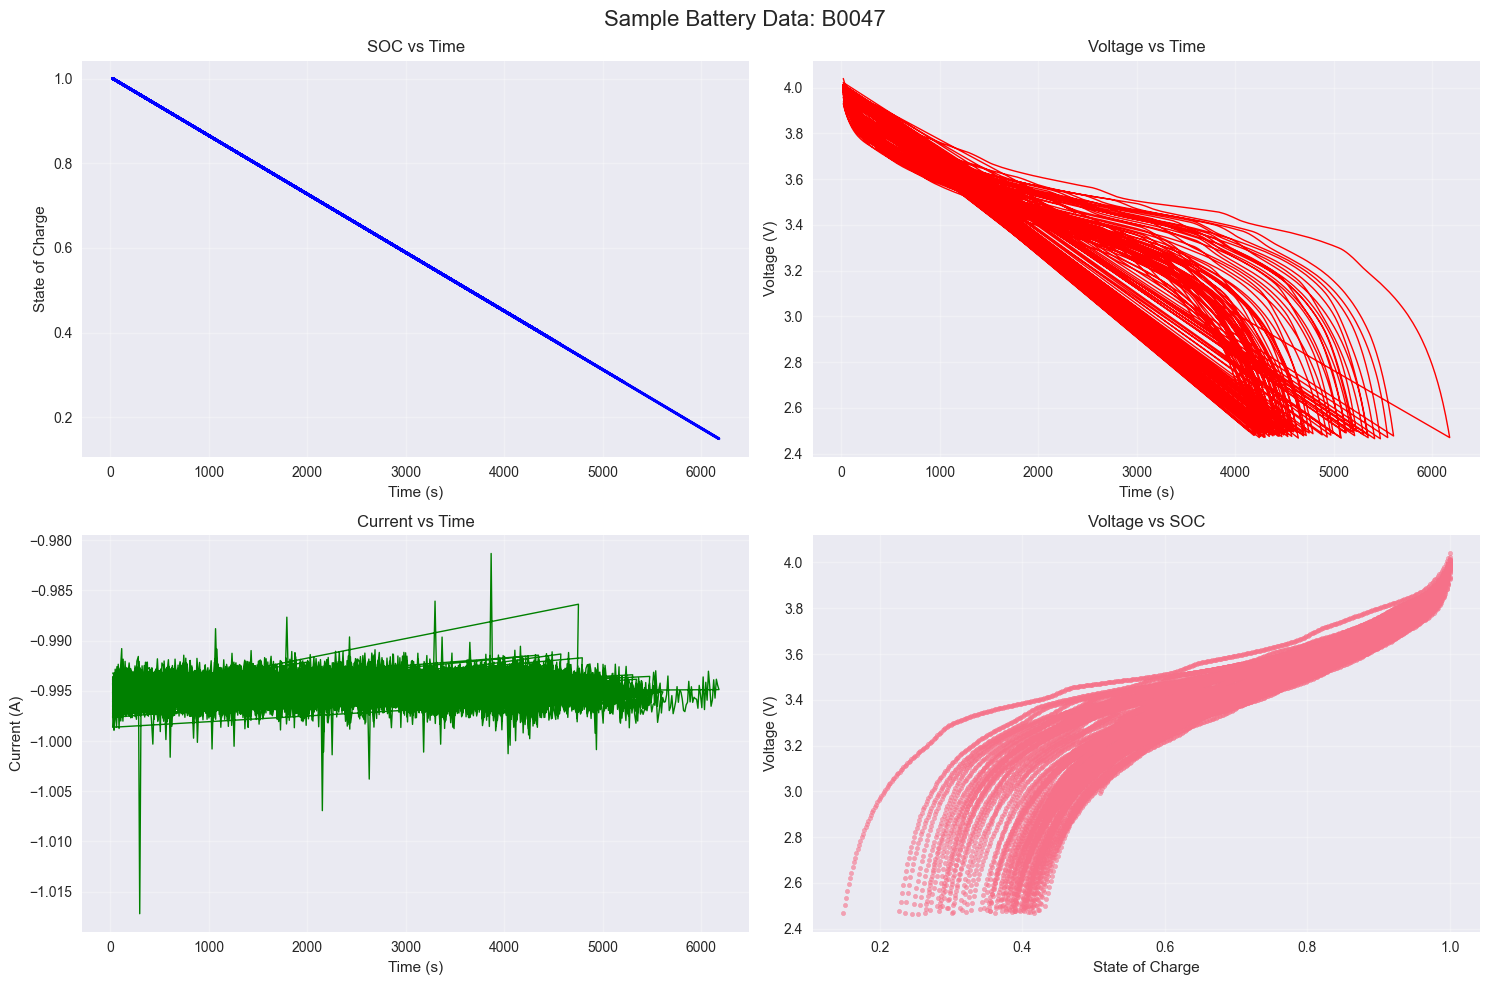

In [3]:
# Take a sample for detailed feature engineering analysis
# Use a single battery's data to demonstrate the pipeline

sample_battery = cleaned_data['battery_id'].iloc[0]
sample_data = cleaned_data[cleaned_data['battery_id'] == sample_battery].copy()

print(f"Sample data from battery: {sample_battery}")
print(f"Sample shape: {sample_data.shape}")
print(f"SOC range in sample: {sample_data['SOC'].min():.3f} - {sample_data['SOC'].max():.3f}")
print(f"Duration: {(sample_data['Time'].max() - sample_data['Time'].min()) / 3600:.2f} hours")

# Visualize sample data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Sample Battery Data: {sample_battery}', fontsize=16)

# SOC vs Time
axes[0, 0].plot(sample_data['Time'], sample_data['SOC'], 'b-', linewidth=2)
axes[0, 0].set_title('SOC vs Time')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('State of Charge')
axes[0, 0].grid(True, alpha=0.3)

# Voltage vs Time
axes[0, 1].plot(sample_data['Time'], sample_data['Voltage_measured'], 'r-', linewidth=1)
axes[0, 1].set_title('Voltage vs Time')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Voltage (V)')
axes[0, 1].grid(True, alpha=0.3)

# Current vs Time
axes[1, 0].plot(sample_data['Time'], sample_data['Current_measured'], 'g-', linewidth=1)
axes[1, 0].set_title('Current vs Time')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Current (A)')
axes[1, 0].grid(True, alpha=0.3)

# Voltage vs SOC
axes[1, 1].scatter(sample_data['SOC'], sample_data['Voltage_measured'], alpha=0.6, s=10)
axes[1, 1].set_title('Voltage vs SOC')
axes[1, 1].set_xlabel('State of Charge')
axes[1, 1].set_ylabel('Voltage (V)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Feature Engineering Pipeline

In [4]:
# Apply feature engineering to sample data
print("Testing feature engineering pipeline on sample data...")
sample_features = engineer_features(sample_data)

print(f"\nFeature Engineering Results:")
print(f"Original data shape: {sample_data.shape}")
print(f"Engineered features shape: {sample_features.shape}")

# Identify feature types
metadata_cols = ['SOC', 'battery_id', 'filename', 'test_id', 'ambient_temperature']
feature_cols = [col for col in sample_features.columns if col not in metadata_cols]

print(f"Number of features: {len(feature_cols)}")
print(f"Target column: SOC")
print(f"Metadata columns: {[col for col in metadata_cols if col in sample_features.columns]}")

# Categorize features
basic_features = [col for col in feature_cols if col in ['voltage', 'current', 'temperature', 'time']]
derived_features = [col for col in feature_cols if any(x in col for x in ['power', 'abs_current', 'ratio', 'energy'])]
change_features = [col for col in feature_cols if '_change' in col]
rolling_features = [col for col in feature_cols if 'rolling' in col]
cumulative_features = [col for col in feature_cols if 'cumulative' in col]
time_features = [col for col in feature_cols if any(x in col for x in ['time_since', 'time_normalized'])]
lag_features = [col for col in feature_cols if '_lag_' in col]
statistical_features = [col for col in feature_cols if any(x in col for x in ['vs_mean', 'percentile'])]

print(f"\nFeature Categories:")
print(f"  Basic measurements: {len(basic_features)} - {basic_features[:3]}...")
print(f"  Derived features: {len(derived_features)} - {derived_features[:3]}...")
print(f"  Rate of change: {len(change_features)} - {change_features[:3]}...")
print(f"  Rolling statistics: {len(rolling_features)} - {rolling_features[:3]}...")
print(f"  Cumulative features: {len(cumulative_features)} - {cumulative_features}")
print(f"  Time-based features: {len(time_features)} - {time_features}")
print(f"  Lag features: {len(lag_features)} - {lag_features[:3]}...")
print(f"  Statistical features: {len(statistical_features)} - {statistical_features[:3]}...")

Testing feature engineering pipeline on sample data...

Feature Engineering Results:
Original data shape: (23332, 11)
Engineered features shape: (23332, 51)
Number of features: 46
Target column: SOC
Metadata columns: ['SOC', 'battery_id', 'filename', 'test_id', 'ambient_temperature']

Feature Categories:
  Basic measurements: 4 - ['voltage', 'current', 'temperature']...
  Derived features: 6 - ['power', 'abs_current', 'voltage_current_ratio']...
  Rate of change: 4 - ['voltage_change', 'current_change', 'temperature_change']...
  Rolling statistics: 15 - ['voltage_rolling_mean_5', 'current_rolling_mean_5', 'temperature_rolling_mean_5']...
  Cumulative features: 2 - ['cumulative_discharge', 'cumulative_energy']
  Time-based features: 2 - ['time_normalized', 'time_since_start']
  Lag features: 9 - ['voltage_lag_1', 'current_lag_1', 'SOC_lag_1']...
  Statistical features: 4 - ['voltage_vs_mean', 'current_vs_mean', 'voltage_percentile']...


## 4. Feature Quality Analysis

In [5]:
# Analyze feature statistics and data quality
print("Analyzing feature quality...")

# Check for data quality issues
nan_counts = sample_features[feature_cols].isnull().sum()
inf_counts = np.isinf(sample_features[feature_cols]).sum()
zero_variance = sample_features[feature_cols].var() == 0

print(f"\nData Quality Checks:")
print(f"Features with NaN values: {(nan_counts > 0).sum()}")
print(f"Features with Inf values: {(inf_counts > 0).sum()}")
print(f"Features with zero variance: {zero_variance.sum()}")

if (nan_counts > 0).sum() > 0:
    print(f"\nFeatures with NaN:")
    print(nan_counts[nan_counts > 0].head())

if (inf_counts > 0).sum() > 0:
    print(f"\nFeatures with Inf:")
    print(inf_counts[inf_counts > 0].head())

if zero_variance.sum() > 0:
    print(f"\nFeatures with zero variance:")
    print(zero_variance[zero_variance].index.tolist())

# Show feature statistics for first 10 features
print(f"\nFeature Statistics (first 10 features):")
feature_stats = sample_features[feature_cols[:10]].describe()
print(feature_stats.round(4))

Analyzing feature quality...

Data Quality Checks:
Features with NaN values: 0
Features with Inf values: 0
Features with zero variance: 0

Feature Statistics (first 10 features):
          voltage     current  temperature  Current_load  Voltage_load  \
count  23332.0000  23332.0000   23332.0000    23332.0000    23332.0000   
mean       3.4087     -0.9949       8.3634        1.0011        2.8319   
std        0.2926      0.0011       1.4676        0.0524        0.6969   
min        2.4655     -1.0172       3.8825        0.9998        0.9991   
25%        3.2551     -0.9956       7.3800        1.0000        2.6560   
50%        3.4447     -0.9949       8.1709        1.0000        2.8590   
75%        3.6081     -0.9942       9.2650        1.0000        3.0430   
max        4.0393     -0.9813      13.2494        4.0990       97.0000   

             time       power  abs_current  voltage_current_ratio      energy  
count  23332.0000  23332.0000   23332.0000             23332.0000  23332.0

## 5. Feature Visualization

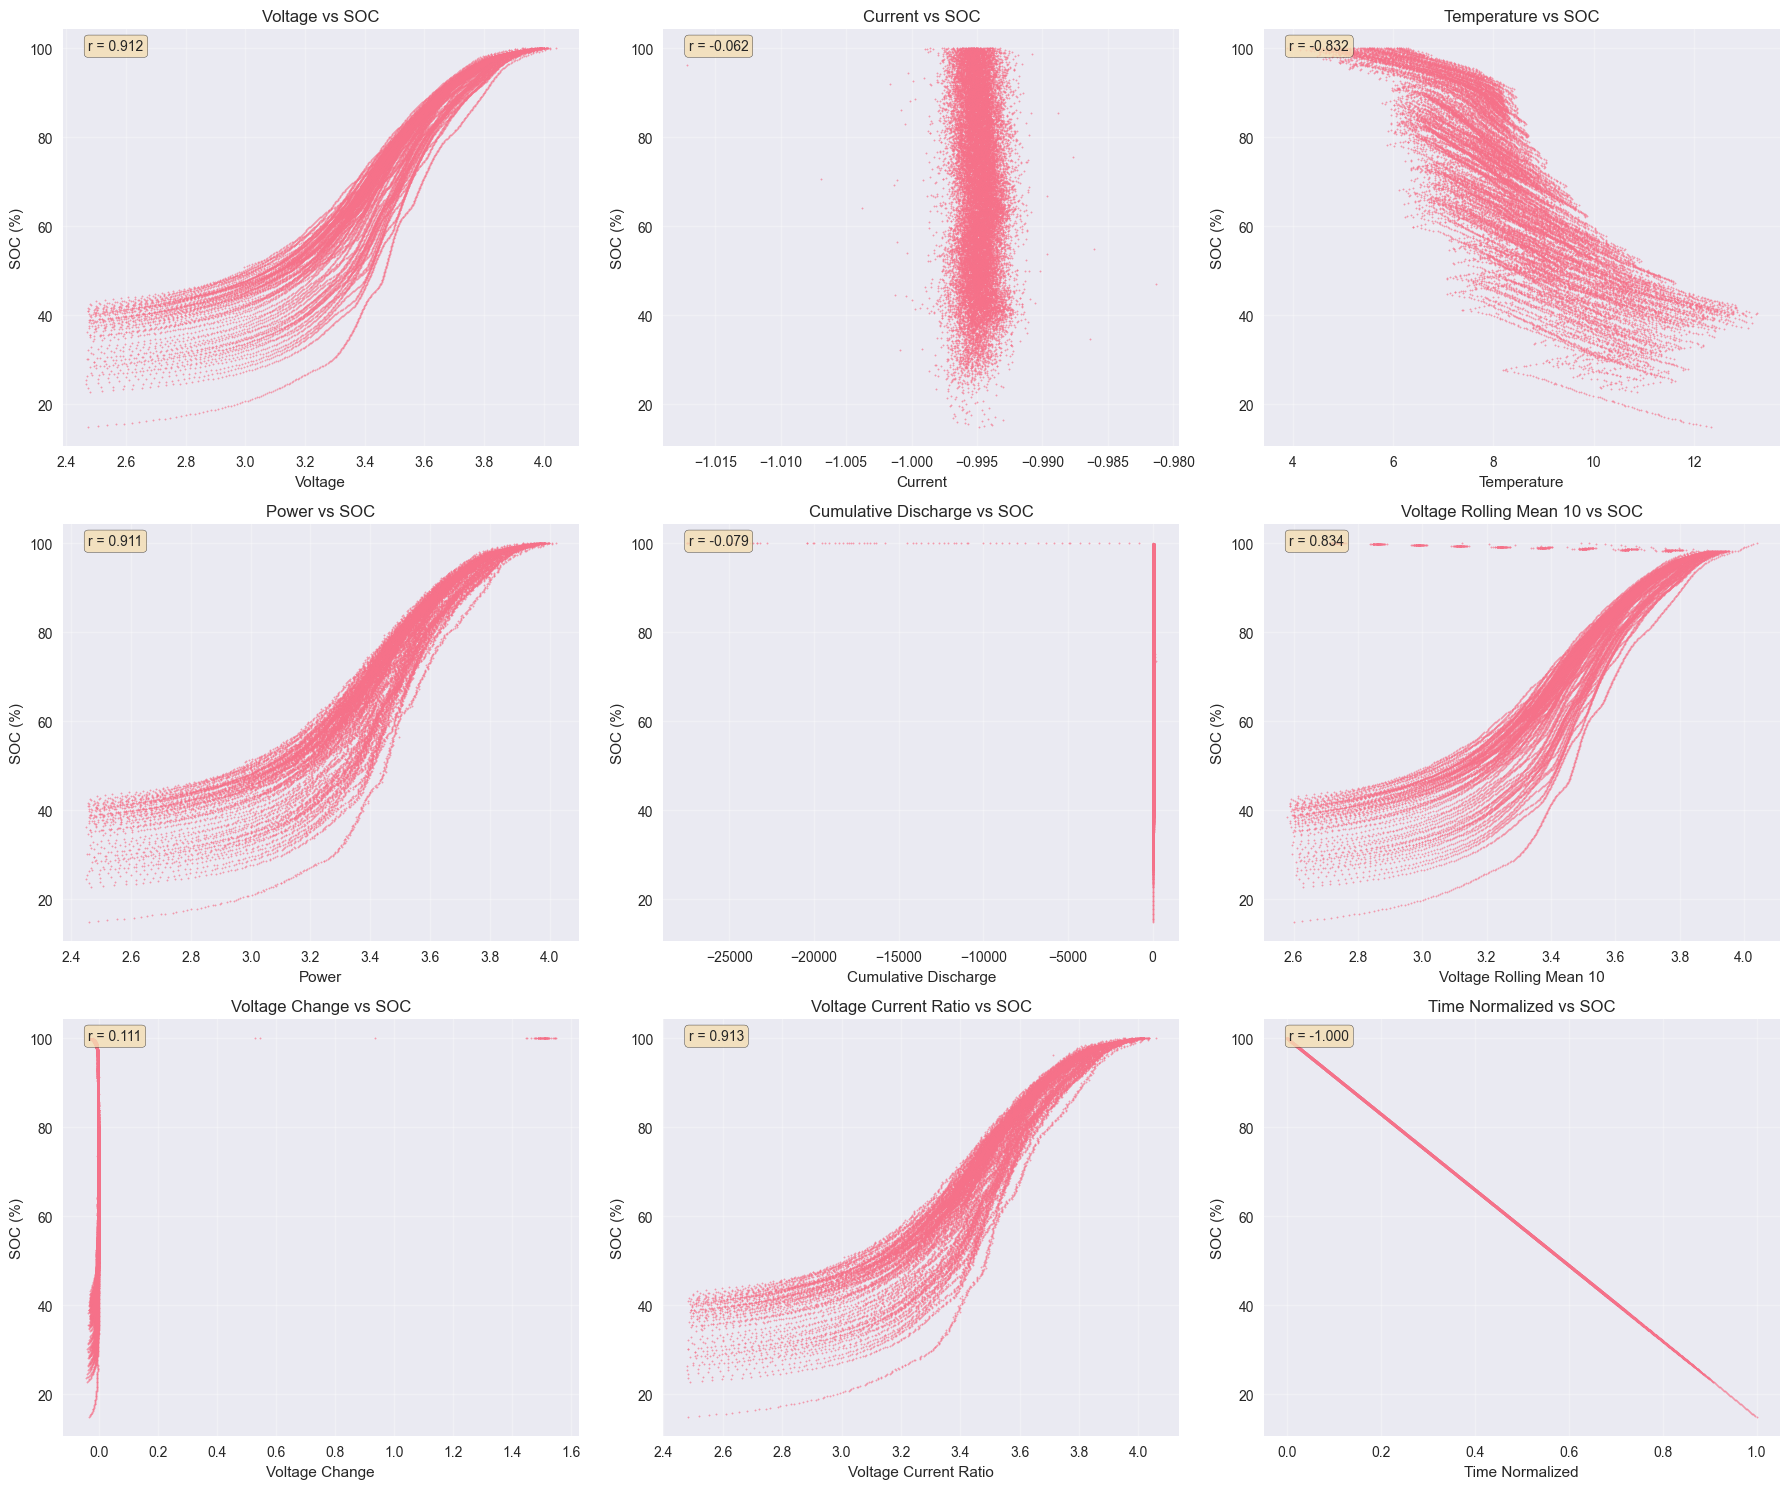

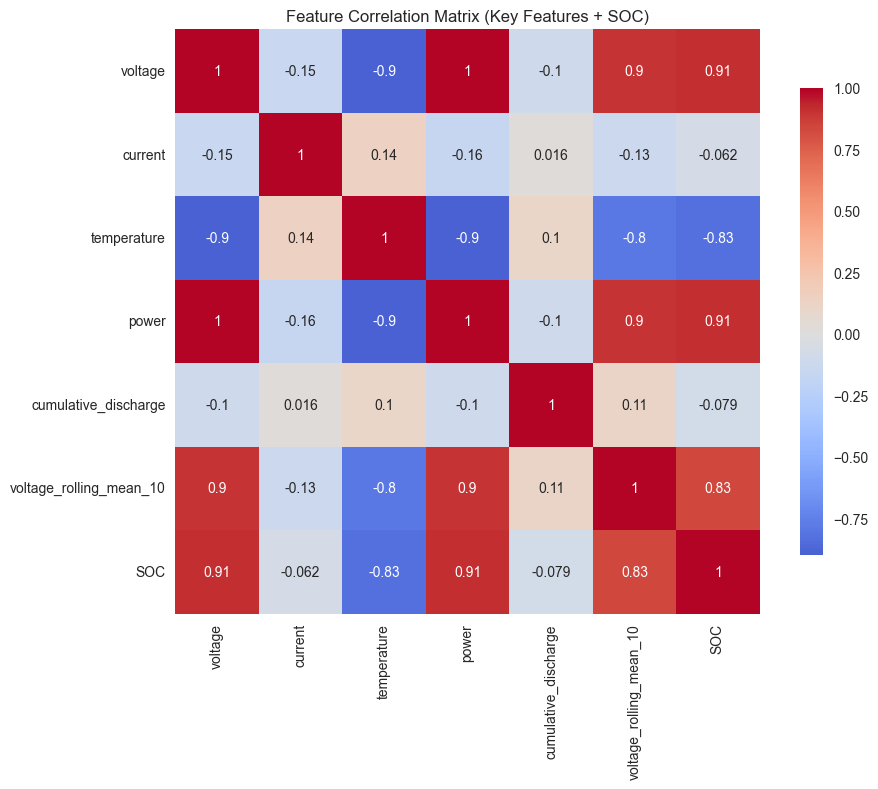

In [6]:
# Visualize key features and their relationships with SOC
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

# Select key features to visualize
key_features = [
    'voltage', 'current', 'temperature', 'power', 'cumulative_discharge',
    'voltage_rolling_mean_10', 'voltage_change', 'voltage_current_ratio', 'time_normalized'
]

for i, feature in enumerate(key_features):
    if i < 9 and feature in sample_features.columns:
        # Scatter plot of feature vs SOC
        axes[i].scatter(sample_features[feature], sample_features['SOC'] * 100, alpha=0.6, s=1)
        axes[i].set_xlabel(feature.replace('_', ' ').title())
        axes[i].set_ylabel('SOC (%)')
        axes[i].set_title(f'{feature.replace("_", " ").title()} vs SOC')
        axes[i].grid(alpha=0.3)
        
        # Add correlation coefficient
        corr = sample_features[feature].corr(sample_features['SOC'])
        axes[i].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[i].transAxes, 
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    elif feature not in sample_features.columns:
        axes[i].text(0.5, 0.5, f'{feature}\nnot found', ha='center', va='center', 
                    transform=axes[i].transAxes)
        axes[i].set_title(f'{feature} (Missing)')

plt.tight_layout()
plt.show()

# Feature correlation heatmap (for a subset of features)
correlation_features = key_features[:6]  # Top 6 for readability
available_features = [f for f in correlation_features if f in sample_features.columns]

if len(available_features) > 1:
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    corr_matrix = sample_features[available_features + ['SOC']].corr()
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, ax=ax, cbar_kws={'shrink': 0.8})
    ax.set_title('Feature Correlation Matrix (Key Features + SOC)')
    
    plt.tight_layout()
    plt.show()

## 6. Feature Importance Analysis

Calculating feature importance...
Computing mutual information scores...
Training Random Forest for feature importance...

Top 15 Features by Mutual Information:
SOC_lag_1                  7.5148
time_normalized            6.9472
time                       6.9471
time_since_start           6.9471
SOC_lag_3                  6.5178
SOC_lag_5                  6.0119
voltage_percentile         1.5763
voltage_lag_5              1.5730
voltage_lag_3              1.5432
voltage_lag_1              1.5144
voltage_current_ratio      1.5058
voltage_vs_mean            1.5003
voltage                    1.5003
voltage_rolling_mean_10    1.4995
voltage_rolling_mean_5     1.4988
dtype: float64

Top 15 Features by Random Forest Importance:
time_normalized            0.3310
time_since_start           0.2748
time                       0.2533
SOC_lag_1                  0.1353
SOC_lag_3                  0.0048
SOC_lag_5                  0.0008
cumulative_energy          0.0000
temperature                0.

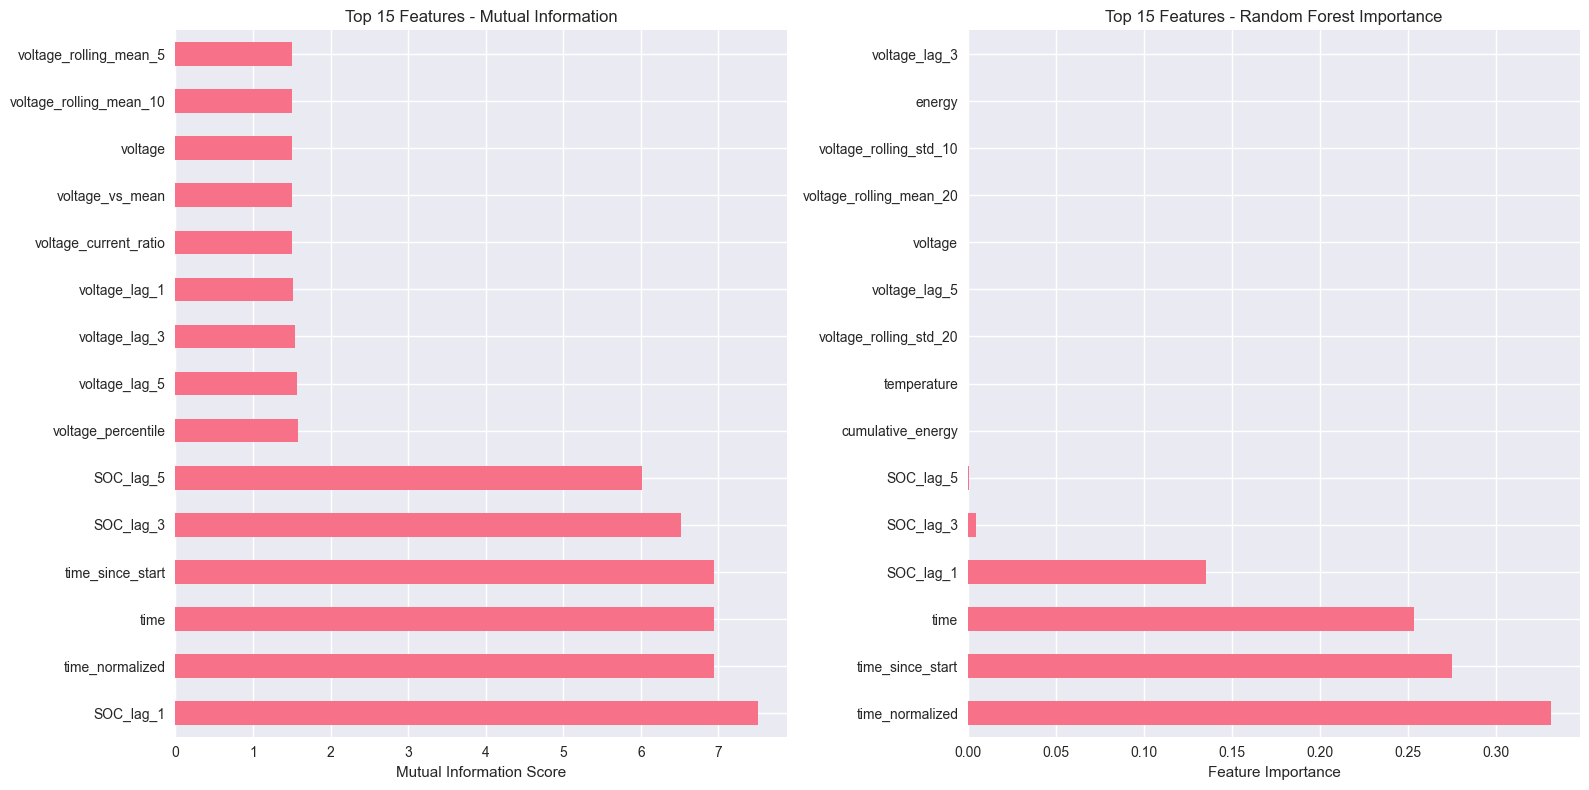


Feature importance analysis complete!


In [7]:
# Calculate feature importance using mutual information and random forest
if len(sample_features) > 100:
    print("Calculating feature importance...")
    
    # Prepare data for importance analysis
    X = sample_features[feature_cols].copy()
    y = sample_features['SOC']
    
    # Handle any remaining NaN/inf values
    X_clean = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Mutual information
    print("Computing mutual information scores...")
    mi_scores = mutual_info_regression(X_clean, y, random_state=42)
    mi_importance = pd.Series(mi_scores, index=feature_cols).sort_values(ascending=False)
    
    # Random forest feature importance
    print("Training Random Forest for feature importance...")
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_clean, y)
    rf_importance = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    
    print(f"\nTop 15 Features by Mutual Information:")
    print(mi_importance.head(15).round(4))
    
    print(f"\nTop 15 Features by Random Forest Importance:")
    print(rf_importance.head(15).round(4))
    
    # Visualize feature importance
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Mutual Information
    mi_importance.head(15).plot(kind='barh', ax=axes[0])
    axes[0].set_title('Top 15 Features - Mutual Information')
    axes[0].set_xlabel('Mutual Information Score')
    
    # Random Forest
    rf_importance.head(15).plot(kind='barh', ax=axes[1])
    axes[1].set_title('Top 15 Features - Random Forest Importance')
    axes[1].set_xlabel('Feature Importance')
    
    plt.tight_layout()
    plt.show()
    
    # Save feature importance for later use
    feature_importance = {
        'mutual_info': mi_importance.to_dict(),
        'random_forest': rf_importance.to_dict(),
        'top_features_mi': mi_importance.head(15).index.tolist(),
        'top_features_rf': rf_importance.head(15).index.tolist()
    }
    
    print(f"\nFeature importance analysis complete!")
    
else:
    print("Insufficient data for feature importance analysis")
    feature_importance = None

## 7. Full Dataset Feature Engineering

In [8]:
# Apply feature engineering to the full cleaned dataset
print("Applying feature engineering to full dataset...")
print("Note: This may take several minutes for large datasets")

# Process data by battery to manage memory and show progress
unique_batteries = cleaned_data['battery_id'].unique()
engineered_data_list = []

print(f"Processing {len(unique_batteries)} unique batteries...")

for battery_id in tqdm(unique_batteries, desc="Engineering features"):
    # Get data for this battery
    battery_data = cleaned_data[cleaned_data['battery_id'] == battery_id].copy()
    
    # Apply feature engineering
    try:
        engineered_battery_data = engineer_features(battery_data)
        engineered_data_list.append(engineered_battery_data)
    except Exception as e:
        print(f"Error processing battery {battery_id}: {e}")
        continue

# Combine all engineered data
if engineered_data_list:
    full_engineered_data = pd.concat(engineered_data_list, ignore_index=True)
    
    print(f"\nFull dataset feature engineering complete!")
    print(f"Final shape: {full_engineered_data.shape}")
    print(f"Number of features: {len([col for col in full_engineered_data.columns if col not in metadata_cols])}")
    print(f"Memory usage: {full_engineered_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Data quality check on full dataset
    feature_cols_full = [col for col in full_engineered_data.columns if col not in metadata_cols]
    nan_count = full_engineered_data[feature_cols_full].isnull().sum().sum()
    inf_count = np.isinf(full_engineered_data[feature_cols_full]).sum().sum()
    
    print(f"\nData quality check:")
    print(f"Total NaN values: {nan_count}")
    print(f"Total Inf values: {inf_count}")
    
else:
    print("❌ No data was successfully processed!")
    full_engineered_data = None

Applying feature engineering to full dataset...
Note: This may take several minutes for large datasets
Processing 30 unique batteries...


Engineering features: 100%|██████████| 30/30 [00:00<00:00, 34.62it/s]



Full dataset feature engineering complete!
Final shape: (541510, 51)
Number of features: 46
Memory usage: 260.28 MB

Data quality check:
Total NaN values: 0
Total Inf values: 0


## 8. Save Engineered Features

In [9]:
# Save engineered features and analysis results
if full_engineered_data is not None:
    
    # Save full engineered dataset
    engineered_data_path = OUTPUT_DIR / 'engineered_features.csv'
    full_engineered_data.to_csv(engineered_data_path, index=False)
    print(f"Saved full engineered dataset to {engineered_data_path}")
    print(f"File size: {engineered_data_path.stat().st_size / 1024**2:.2f} MB")
    
    # Save sample engineered features for quick access
    sample_features_path = OUTPUT_DIR / 'sample_engineered_features.pkl'
    with open(sample_features_path, 'wb') as f:
        pickle.dump(sample_features, f)
    print(f"Saved sample engineered features to {sample_features_path}")
    
    # Save feature importance if calculated
    if 'feature_importance' in locals() and feature_importance is not None:
        importance_path = OUTPUT_DIR / 'feature_importance.pkl'
        with open(importance_path, 'wb') as f:
            pickle.dump(feature_importance, f)
        print(f"Saved feature importance analysis to {importance_path}")
    
    # Save feature engineering metadata
    feature_metadata = {
        'total_features': len(feature_cols_full) if 'feature_cols_full' in locals() else len(feature_cols),
        'feature_categories': {
            'basic_measurements': len(basic_features),
            'derived_features': len(derived_features),
            'change_features': len(change_features),
            'rolling_features': len(rolling_features),
            'cumulative_features': len(cumulative_features),
            'time_features': len(time_features),
            'lag_features': len(lag_features),
            'statistical_features': len(statistical_features)
        },
        'data_shape': full_engineered_data.shape,
        'unique_batteries': full_engineered_data['battery_id'].nunique(),
        'soc_range': (full_engineered_data['SOC'].min(), full_engineered_data['SOC'].max()),
        'data_quality': {
            'nan_values': nan_count if 'nan_count' in locals() else 0,
            'inf_values': inf_count if 'inf_count' in locals() else 0
        }
    }
    
    metadata_path = OUTPUT_DIR / 'feature_engineering_metadata.pkl'
    with open(metadata_path, 'wb') as f:
        pickle.dump(feature_metadata, f)
    print(f"Saved feature engineering metadata to {metadata_path}")
    
    print(f"\n✅ Feature engineering complete!")
    print(f"Ready for sequential data preparation (Notebook 04)")
    
else:
    print("❌ No engineered features to save")

Saved full engineered dataset to processed_data/engineered_features.csv
File size: 462.99 MB
Saved sample engineered features to processed_data/sample_engineered_features.pkl
Saved feature importance analysis to processed_data/feature_importance.pkl
Saved feature engineering metadata to processed_data/feature_engineering_metadata.pkl

✅ Feature engineering complete!
Ready for sequential data preparation (Notebook 04)


## Summary

This notebook has successfully:

### ✅ Completed Tasks:
1. **Data Loading**: Loaded cleaned discharge data from `02_data_cleaning.ipynb`
2. **Feature Engineering**: Created comprehensive feature set with 40+ engineered features
3. **Feature Categories**: Implemented multiple feature types:
   - Basic measurements (voltage, current, temperature, time)
   - Derived features (power, ratios, absolute values)
   - Rate of change features (derivatives)
   - Rolling statistics (multiple window sizes)
   - Cumulative features (discharge capacity, energy)
   - Time-based features (normalized time, time since start)
   - Lag features (historical values)
   - Statistical features (deviations, percentiles)
4. **Feature Analysis**: Conducted correlation and importance analysis
5. **Quality Control**: Comprehensive data quality checks and validation

### 📊 Key Results:
- **Feature Count**: 40+ engineered features from basic measurements
- **Data Quality**: Proper handling of NaN/Inf values and data validation
- **Feature Importance**: Identified most predictive features for SOC estimation
- **Scalable Pipeline**: Efficient processing for large datasets

### 📁 Output Files:
- `processed_data/engineered_features.csv`: Full dataset with all engineered features
- `processed_data/sample_engineered_features.pkl`: Sample dataset for quick analysis
- `processed_data/feature_importance.pkl`: Feature importance analysis results
- `processed_data/feature_engineering_metadata.pkl`: Pipeline metadata and statistics

### 🚀 Next Steps:
1. **Notebook 04**: Sequential Data Preparation for Deep Learning Models
2. **Notebook 05**: Final Data Processing and Train/Val/Test Splits

The engineered features are now ready for both conventional ML models and as inputs to sequential models for deep learning approaches.